In [1]:
import torch
from torch.nn.functional import pad
from torch.utils.data import DataLoader, Dataset

In [2]:
from tqdm.auto import tqdm

/run/media/john/Secondary/Projects/ML/CRFLM/crf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from models.model import CustomModel
from models.model import CRFModel

In [4]:
from datasets import load_from_disk

In [5]:
import tokenmonster

In [6]:
path = "checkpoints/crf_model.pt"

In [7]:
tokenizer_file = "english-8000-balanced-v1"

In [8]:
vocab = tokenmonster.load_multiprocess_safe(tokenizer_file)

In [9]:
initial_vocab_size = len(vocab)

In [10]:
# initial_vocab_size is 8000, so largest valid index is 7999

In [11]:
pad_idx = initial_vocab_size # max valid index is now 8000
eos_idx = initial_vocab_size + 1 # max valid index is now 8001

In [12]:
vocab_size = initial_vocab_size + 2

In [13]:
question_len = 256
context_len = 512
answer_len = 256
assert context_len >= answer_len

In [14]:
embedding_dim = 512
num_heads = 8
target_len = answer_len
num_helix_layers = 1
num_single_strand_layers = 1
phm_factor = 4
lm_head_phm_factor = 2
beam = 32
low_rank = 16

In [15]:
squad_train_file = "data/squad_train"
dolly_test_file = "data/closed"

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
squad = load_from_disk(squad_train_file)
dolly = load_from_disk(dolly_test_file)

In [18]:
def collate_fn(batch, question_key, context_key, answer_key):
    """
    Each batch has 3 elements: instruction, context, response
    However since their lengths may vary, we need to pad them.

    For response, must ensure that we add eos token and then begin padding.
    """
    questions = []
    contexts = []
    answers = []

    for elem in batch:
        i = elem[question_key]
        c = elem[context_key]
        r = elem[answer_key]

        questions.append(i)
        contexts.append(c)
        answers.append(r)

    # Pad instructions to question_len
    questions = [pad(i, (0, question_len - len(i)), value=pad_idx) for i in questions]

    # Pad contexts to context_len
    contexts = [pad(c, (0, context_len - len(c)), value=pad_idx) for c in contexts]

    # Pad responses to answer_len
    # though first making sure that eos token is added to end of each response
    eos_append = torch.tensor([eos_idx])
    answers = [torch.cat((r[:answer_len-1], eos_append)) for r in answers]
    answers = [pad(r, (0, answer_len - len(r)), value=pad_idx) for r in answers]

    return torch.stack(questions), torch.stack(contexts), torch.stack(answers)

In [19]:
def dolly_collate_fn(batch):
    return collate_fn(batch, "instruction", "context", "response")

In [20]:
def squad_collate_fn(batch):
    return collate_fn(batch, "question", "context", "answers")

In [21]:
batch_size = 32

In [22]:
dollyDataloader = DataLoader(dolly, batch_size=batch_size, shuffle=True, collate_fn=dolly_collate_fn)

In [23]:
squadDataloader = DataLoader(squad, batch_size=batch_size, shuffle=True, collate_fn=squad_collate_fn)

In [24]:
model = CustomModel(embedding_dim, num_heads, target_len, vocab_size, num_helix_layers=num_helix_layers, num_single_strand_layers=num_single_strand_layers, phm_factor=phm_factor, lm_head_phm_factor=lm_head_phm_factor)

In [25]:
model = model.to(device)

In [26]:
crf = CRFModel(model, vocab_size, beam, low_rank, pad_idx)

In [27]:
crf = crf.to(device)

In [28]:
print(f'CRF has {sum(p.numel() for p in crf.parameters() if p.requires_grad):,} trainable parameters')

CRF has 9,059,400 trainable parameters


In [29]:
from torch.optim import Adam

In [30]:
optm = Adam(crf.parameters(), lr=0.001)

In [31]:
from loss_functions.unlikelihood_loss import unlikelihood_loss

In [32]:
k = 3

In [65]:
epochs = 500

In [34]:
losses = []

In [35]:
squad_iter = iter(squadDataloader)
dolly_iter = iter(dollyDataloader)

In [36]:
# uncomment to load checkpoint
checkpoint = torch.load(path)
crf.load_state_dict(checkpoint['model_state_dict'])
optm.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint['losses']

In [66]:
for epoch in tqdm(range(epochs)):
    try:
        batch = next(squad_iter)
    except StopIteration:
        squad_iter = iter(squadDataloader)
        batch = next(squad_iter)
    question, context, answer = batch
    question = question.to(device)
    context = context.to(device)
    answer = answer.to(device)

    logits, crf_losses = crf(question, context, answer)
    unlike_loss = unlikelihood_loss(logits, answer, k, allow_self_repeats_idx=pad_idx)

    logits = logits.reshape(-1, vocab_size)
    logits_loss = torch.nn.functional.cross_entropy(logits, answer.reshape(-1), ignore_index=pad_idx)
    total_loss = logits_loss + torch.sum(crf_losses) + unlike_loss

    optm.zero_grad()
    losses.append(total_loss.item())
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(crf.parameters(), 1.0)
    optm.step()

100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


In [67]:
import matplotlib.pyplot as plt

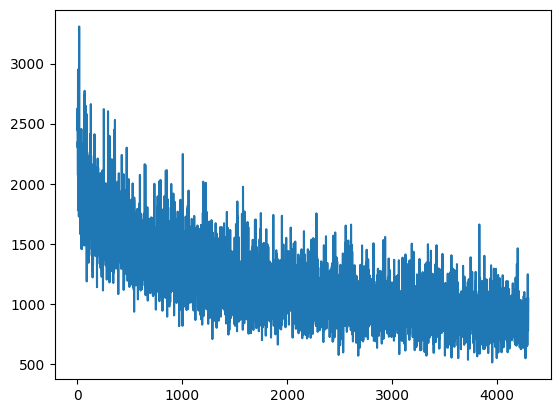

In [68]:
# Plot the losses
plt.plot(losses)

In [69]:
# save general checkpoint to resume training later
path = "checkpoints/crf_model.pt"
torch.save({
    'epoch': len(losses),
    'model_state_dict': crf.state_dict(),
    'optimizer_state_dict': optm.state_dict(),
    'loss': losses[-1],
    'losses': losses
}, path)
print(f"Saved checkpoint to {path}")

Saved checkpoint to checkpoints/crf_model.pt


In [70]:
dolly_test_0 = dolly[0]

In [71]:
instruction, context, response = dolly_test_0["instruction"], dolly_test_0["context"], dolly_test_0["response"]

In [72]:
crf = crf.eval()

In [73]:
instruction = instruction.to(device)
context = context.to(device)

In [74]:
# pad instruction to question_len
instruction = pad(instruction, (0, question_len - len(instruction)), value=pad_idx)

# pad context to context_len
context = pad(context, (0, context_len - len(context)), value=pad_idx)

In [75]:
batched_instruction = instruction.unsqueeze(0)
batched_context = context.unsqueeze(0)

In [76]:
_, tokens = crf.inference(batched_instruction, batched_context)

In [77]:
tokens = tokens[0]

In [78]:
tokens = tokens.to('cpu')

In [79]:
vocab.decode(tokens.tolist())

"18 40 26 developmentized rightsized rightsized 26S from of stu worklor res work that that that that that revolutionia capable of (that convertia capable of (that com ven (Ven (Ven (Ven (Ven (Ven (Ven (Ven (Dark sar ven (Ven (Ven (Vench Leven (Ven (Darkción dark way Idarkción ven dark way I fre ven Levención ven Ledark wayflo archven pu rub vol wor hardven worpu ven Ledar convinced Leven Leworven Lerub beginning to\n                                        orub beginning to\n                                       tin should have those rub beginning to should have those seed ago\n                                        convinced should have those rub cri expressed wor cannot those rub beginning to should have those rub beginning to should have those rub beginning to should have those rub beginning to should have those rub settlement half-should have those rub beginning to should have those rub settlement related to the expressed\n                                        responsible for